# I. Agriculture Water Demand Prediction using LSTM

In this section, we use an LSTM model to use last three years of Crop Sown-Area (`crop_area_ha`), Irrigated Area (`irrigated_area_ha`), Actual Rainfall (`actual_rainfall_mm`), Normal Rainfall (`normal_rainfall_mm`) data to predict `water_demand_m3`.

We load, clean, and preprocess the data before generating sequences for the model. We then create Data Loaders and define the model architecture. Later, we evaluate the model on the test set and generate metrics on the performance in terms of MAE (Mean Absolute Error) and RMSE (Root Mean Square Error).

Finally, we generate synthetic drought scenarios by reducing the `actual_rainfall_mm` to a fraction of its original value and getting the impact on water demand.

## A. Data Preprocessing for LSTM

### 1. Import Libraries and Define Parameters

In [3]:
import json
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
DATAFILE_PATH = 'datafile.csv'

### 2. Load and Clean CSV

In [5]:
df = pd.read_csv(DATAFILE_PATH)
df.columns = [c.strip() for c in df.columns]

dropped_cols = ['production_tonnes', 'yield_t_ha', 'irrigation_fraction']
df = df.drop(columns=dropped_cols)

num_cols = [
    'crop_area_ha','irrigated_area_ha',
    'actual_rainfall_mm','normal_rainfall_mm',
    'cwr_m3_per_ha'
]
for c in num_cols + ['water_demand_m3']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df['year'] = pd.to_numeric(df['year'], errors='coerce')

### 3. Feature Engineering

We calculate the `rainfall_anomaly_mm` as the absolute difference between `actual_rainfall_mm` and `normal_rainfall_mm`. We also convert `state_id` and `crop_id` into an embedding that will also be passed to the model.

In [6]:
# rainfall anomaly
df['rainfall_anomaly_mm'] = df['actual_rainfall_mm'] - df['normal_rainfall_mm']
num_cols.append('rainfall_anomaly_mm')

# categorical encodings
state2id = {s:i for i,s in enumerate(sorted(df['state'].unique()))}
crop2id = {s:i for i,s in enumerate(sorted(df['crop'].unique()))}
df['state_id'] = df['state'].map(state2id)
df['crop_id'] = df['crop'].map(crop2id)

### 4. Handle Duplicates in the DataFrame

In [7]:
collapsed_df = df.groupby(['state','year','crop'], as_index=False).agg({
    'crop_area_ha':'first',
    'irrigated_area_ha':'mean',
    'actual_rainfall_mm':'mean',
    'normal_rainfall_mm':'mean',
    'cwr_m3_per_ha':'mean',
    'water_demand_m3':'mean',
    'drought_flag':'max',
    'rainfall_anomaly_mm':'mean',
    'state_id':'first',
    'crop_id':'first'
})

### 6. Train - Validation - Test Split

In [8]:
VAL_SIZE = 0.2
TEST_SIZE = 0.25
SEED = 42

train_df, test_df = train_test_split(collapsed_df, test_size=TEST_SIZE, random_state=SEED)
train_df, val_df  = train_test_split(train_df, test_size=VAL_SIZE, random_state=SEED)

### 7. Scale the Data to avoid Magnitude Bias

The target `water_demand_m3` is scaled separately from the other features to prevent data leakage to the model. The scaler is kept in memory to perform inverse transformations on the predictions generated by the model. The other feature columns are scaled together using `StandardScaler`.

In [9]:
non_scale_cols = ["state","year","crop","drought_flag","state_id","crop_id", "water_demand_m3"]

scaler = StandardScaler()
scaler.fit(train_df[num_cols])

target_scaler = StandardScaler()
target_scaler.fit(train_df[["water_demand_m3"]])

train_df[["water_demand_m3"]] = pd.DataFrame(
    target_scaler.transform(train_df[["water_demand_m3"]]),
    index=train_df.index,
    columns=["water_demand_m3"]
)

val_df[["water_demand_m3"]] = pd.DataFrame(
    target_scaler.transform(val_df[["water_demand_m3"]]),
    index=val_df.index,
    columns=["water_demand_m3"]
)

test_df[["water_demand_m3"]] = pd.DataFrame(
    target_scaler.transform(test_df[["water_demand_m3"]]),
    index=test_df.index,
    columns=["water_demand_m3"]
)

def scale_and_merge(df, scaler, scale_cols, non_scale_cols):
    scaled = scaler.transform(df[scale_cols])
    scaled_df = pd.DataFrame(scaled, columns=num_cols, index=df.index)
    return pd.concat([scaled_df, df[non_scale_cols]], axis=1)

train_scaled = scale_and_merge(train_df, scaler, num_cols, non_scale_cols)
val_scaled   = scale_and_merge(val_df, scaler, num_cols, non_scale_cols)
test_scaled  = scale_and_merge(test_df, scaler, num_cols, non_scale_cols)

### 8. Generate Sequences

Here we generate the time-series that will be fed to the LSTM to give it temporal-awareness.

In [10]:
CONTEXT = 3  # previous data (number of years) that the model should use to predict future demand
HORIZON = 1

In [11]:
def build_sequences(df_in, group_cols=['state','crop'], time_col='year',
                    T=CONTEXT, H=HORIZON, target_col='water_demand_m3', feature_cols=None):
    sequences = []
    if feature_cols is None:
      feature_cols = [c for c in df_in.select_dtypes(include=[np.number]).columns if c != target_col]

    for _, gdf in df_in.groupby(group_cols):
        gdf = gdf.sort_values(time_col)
        if feature_cols is None:
            feature_cols = [c for c in gdf.select_dtypes(include=[np.number]).columns if c not in [target_col]]
        arr_feat = gdf[feature_cols].to_numpy(dtype=float)
        arr_target = gdf[target_col].to_numpy(dtype=float)
        years = gdf[time_col].to_numpy()

        for i in range(T, len(gdf)-H+1):
            Xpast = arr_feat[i-T:i]
            Yfuture = arr_target[i:i+H]
            sequences.append({
                "Xpast": Xpast,
                "Yfuture": Yfuture,
                "start_year": int(years[i-T]),
                "end_year": int(years[i+H-1])
            })
    return sequences

In [12]:
feature_cols = [
    'state_id','crop_id','crop_area_ha','irrigated_area_ha', 'drought_flag',
    'actual_rainfall_mm','normal_rainfall_mm','rainfall_anomaly_mm','cwr_m3_per_ha'
]

# Build sequences per split
train_sequences = build_sequences(train_scaled, feature_cols=feature_cols)
val_sequences   = build_sequences(val_scaled, feature_cols=feature_cols)
test_sequences  = build_sequences(test_scaled, feature_cols=feature_cols)

print(f"Train seqs: {len(train_sequences)}, Val seqs: {len(val_sequences)}, Test seqs: {len(test_sequences)}")


Train seqs: 1649, Val seqs: 272, Test seqs: 571


## B. LSTM Model

### 1. Import Libraries

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

### 2. Convert numpy arrays to PyTorch tensors

In [14]:
def sequences_to_arrays(sequences, H=1):
    X = np.stack([s['Xpast'] for s in sequences])
    y = np.stack([s['Yfuture'] for s in sequences])
    return X, y

X_train, y_train = sequences_to_arrays(train_sequences)
X_val, y_val     = sequences_to_arrays(val_sequences)
X_test, y_test   = sequences_to_arrays(test_sequences)

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)
X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

print("X_train_t shape:", X_train_t.shape)
print("y_train_t shape:", y_train_t.shape)


X_train_t shape: torch.Size([1649, 3, 9])
y_train_t shape: torch.Size([1649, 1])


### 3. Create DataLoaders

In [15]:
# --- Build column index mapping once ---
cat_cols  = ['state_id', 'crop_id']
cont_cols = [c for c in feature_cols if c not in cat_cols]

# Map feature names to indices
col2idx = {c: i for i, c in enumerate(feature_cols)}
cat_idx = [col2idx[c] for c in cat_cols]
cont_idx = [col2idx[c] for c in cont_cols]

# --- Helper function to extract categorical and continuous arrays ---
def sequences_to_arrays_emb(sequences, cat_idx, cont_idx):
    X_cat = np.stack([s['Xpast'][:, cat_idx] for s in sequences])
    X_cont = np.stack([s['Xpast'][:, cont_idx] for s in sequences])
    y = np.stack([s['Yfuture'] for s in sequences])
    return X_cat, X_cont, y

# Extract arrays safely
X_train_cat, X_train_cont, y_train = sequences_to_arrays_emb(train_sequences, cat_idx, cont_idx)
X_val_cat, X_val_cont, y_val = sequences_to_arrays_emb(val_sequences, cat_idx, cont_idx)
X_test_cat, X_test_cont, y_test = sequences_to_arrays_emb(test_sequences, cat_idx, cont_idx)

# Convert to PyTorch tensors
X_train_cat_t = torch.tensor(X_train_cat, dtype=torch.long)
X_train_cont_t = torch.tensor(X_train_cont, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_cat_t = torch.tensor(X_val_cat, dtype=torch.long)
X_val_cont_t = torch.tensor(X_val_cont, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)

X_test_cat_t = torch.tensor(X_test_cat, dtype=torch.long)
X_test_cont_t = torch.tensor(X_test_cont, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

# --- Create TensorDatasets ---
train_dataset = TensorDataset(X_train_cat_t, X_train_cont_t, y_train_t)
val_dataset   = TensorDataset(X_val_cat_t, X_val_cont_t, y_val_t)
test_dataset  = TensorDataset(X_test_cat_t, X_test_cont_t, y_test_t)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader), "Test batches:", len(test_loader))

Train batches: 103 Val batches: 17 Test batches: 36


### 4. Define LSTM model

In [16]:
EPOCHS = 60
LR = 0.0001
DROPOUT = 0.3
HIDDEN_DIM = 32

The features `crop_id` and `state_id` are passed to the model as **embeddings** instead of one-hot encoding. This allows the model to understand crops and states in a higher-dimensional space.

In [17]:
class LSTMForecastWithEmbeddings(nn.Module):
    def __init__(self, num_states, num_crops, emb_dim,
                 num_cont_features, hidden_dim, output_dim, num_layers, dropout):
        super().__init__()

        self.state_emb = nn.Embedding(num_states, emb_dim)
        self.crop_emb  = nn.Embedding(num_crops, emb_dim)

        # Total input dim = embedding dims + numeric features
        input_dim = 2*emb_dim + num_cont_features

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_cat, x_cont):
        """
        x_cat: (batch, T, 2) -> state_id, crop_id
        x_cont: (batch, T, num_cont_features)
        """
        # Embeddings
        state_emb = self.state_emb(x_cat[:,:,0].long())
        crop_emb  = self.crop_emb(x_cat[:,:,1].long())

        # Concatenate embeddings with continuous features
        x = torch.cat([state_emb, crop_emb, x_cont], dim=-1)

        # LSTM
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


### 5. Instantiate and Train the Model

We are using `dropout` and `learning_rate` scheduling to avoid overfitting. Finally, we also plot the training/validation loss curve.

Epoch 1: Train Loss = 1.0199, Val Loss = 0.9149
Epoch 5: Train Loss = 0.3160, Val Loss = 0.1901
Epoch 10: Train Loss = 0.0918, Val Loss = 0.0860
Epoch 15: Train Loss = 0.0560, Val Loss = 0.0726
Epoch 20: Train Loss = 0.0432, Val Loss = 0.0629
Epoch 25: Train Loss = 0.0358, Val Loss = 0.0568
Epoch 30: Train Loss = 0.0311, Val Loss = 0.0555
Epoch 35: Train Loss = 0.0296, Val Loss = 0.0538
Epoch 40: Train Loss = 0.0278, Val Loss = 0.0527
Epoch 45: Train Loss = 0.0279, Val Loss = 0.0537
Epoch 50: Train Loss = 0.0260, Val Loss = 0.0530
Epoch 55: Train Loss = 0.0275, Val Loss = 0.0522
Epoch 60: Train Loss = 0.0261, Val Loss = 0.0527



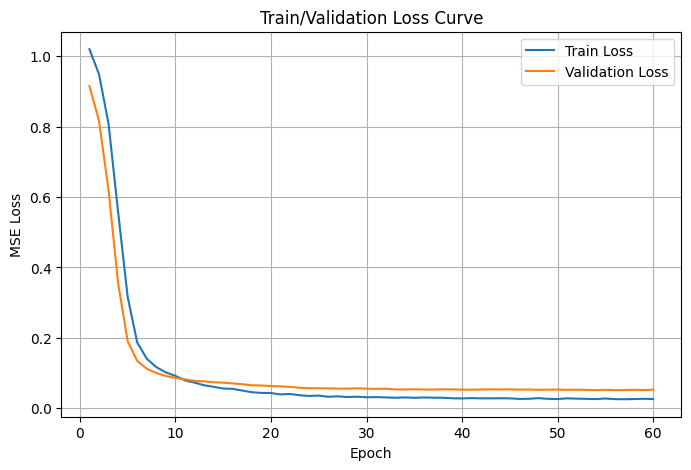

In [18]:
num_states = len(state2id)
num_crops  = len(crop2id)
num_cont_features = len(cont_cols)

model = LSTMForecastWithEmbeddings(
    num_states=num_states,
    num_crops=num_crops,
    emb_dim=3,
    num_cont_features=num_cont_features,
    hidden_dim=HIDDEN_DIM,
    output_dim=1,
    num_layers=2,
    dropout=DROPOUT
)

# --- Loss and optimizer ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)

train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0
    for xb_cat, xb_cont, yb in train_loader:
        optimizer.zero_grad()
        yb = yb.view(-1, 1)
        pred = model(xb_cat, xb_cont)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb_cat.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb_cat, xb_cont, yb in val_loader:
            yb = yb.view(-1, 1)
            pred = model(xb_cat, xb_cont)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb_cat.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

# -------------------------------
# Plotting Loss Curve
# -------------------------------
print()
plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Train/Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## C. Performance Evaluation

### 1. Testing the Model

In [19]:
from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error

We generate predictions from the model and perform an inverse transformation to get the values in `m^3` units. We calculate per-crop `MAE: Mean Average Error` and `RMSE: Root Mean Square Error` and overall `SMAPE: Symmetric Mean Absolute Percentage Error` to evaluate the performance of the model. This gives us a baseline to evaluate the performance of `sequence-to-sequence` models such as `TimeGPT`.

We also plot the predictions of the model against actuals to visualise the performance.

In [20]:
all_preds, all_targets, all_crops = [], [], []

model.eval()
with torch.no_grad():
    for xb_cat, xb_cont, yb in test_loader:
        yb = yb.view(-1, 1)
        pred = model(xb_cat, xb_cont)

        # Collect categorical info
        crop_ids = xb_cat[:, -1, 1].cpu().numpy()
        all_crops.append(crop_ids)

        all_preds.append(pred.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)
all_crops = np.concatenate(all_crops, axis=0)

# Inverse transform predictions and targets to original units
pred_real = target_scaler.inverse_transform(all_preds).ravel()
targets_real = target_scaler.inverse_transform(all_targets).ravel()

# Calculate SMAPE
smape = 100 * np.mean(2 * np.abs(pred_real - targets_real) / (np.abs(pred_real) + np.abs(targets_real)))

# Compute MAE and RMSE per crop
results = []
for crop_id, crop_name in crop2id.items():
    mask = all_crops == crop_name
    if np.sum(mask) == 0:
        continue
    crop_mae = mean_absolute_error(targets_real[mask], pred_real[mask])
    crop_rmse = np.sqrt(mean_squared_error(targets_real[mask], pred_real[mask]))
    results.append((crop_id, crop_mae, crop_rmse))

crop_metrics_df = pd.DataFrame(results, columns=['Crop', 'MAE_m3', 'RMSE_m3'])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
display(crop_metrics_df)
print(f"\n\nSMAPE: {smape: .4f}%")


,Crop,MAE_m3,RMSE_m3
0,rice,3169800192.00,5727048154.89
1,sugarcane,1035882112.00,1632659433.42
2,wheat,986279296.00,1503858006.31




SMAPE:  46.9906%


### 2. Plot Model Predictions

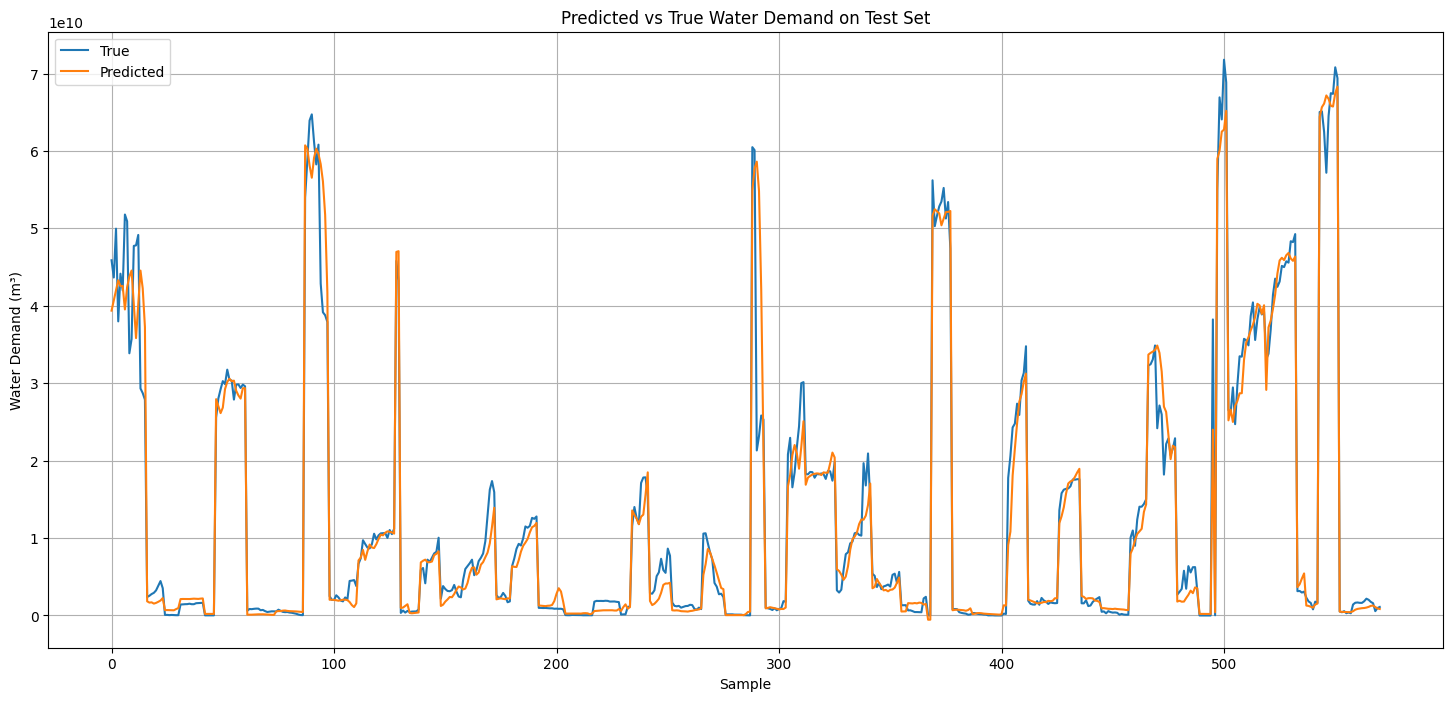

In [21]:
plt.figure(figsize=(18,8))
plt.plot(targets_real, label='True')
plt.plot(pred_real, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Water Demand (m³)')
plt.title('Predicted vs True Water Demand on Test Set')
plt.legend()
plt.grid(True)
plt.show()

### 3. Simulate Drought and obtain Model Predictions

In [22]:
RAINFALL_FACTOR = 0.7

In [23]:
from torch.utils.data import DataLoader, TensorDataset

test_dataset  = TensorDataset(X_test_cat_t, X_test_cont_t, y_test_t)
test_loader_random = DataLoader(test_dataset, batch_size=16, shuffle=True)
sim_X_cat, sim_X_cont, sim_y = next(iter(test_loader_random))


In [24]:
sim_X_cat, sim_X_cont, sim_y = next(iter(test_loader_random))

# --- Baseline prediction (normal rainfall) ---
model.eval()
with torch.no_grad():
    pred_baseline = model(sim_X_cat, sim_X_cont)

# --- Simulate drought by reducing rainfall ---
sim_X_cont_drought = sim_X_cont.clone()

rain_idx   = cont_cols.index('actual_rainfall_mm')
normal_idx = cont_cols.index('normal_rainfall_mm')
anom_idx   = cont_cols.index('rainfall_anomaly_mm')
flag_idx   = cont_cols.index('drought_flag')

# Apply drought factor
sim_X_cont_drought[:, :, rain_idx] *= RAINFALL_FACTOR

# Recompute anomaly (actual - normal)
sim_X_cont_drought[:, :, anom_idx] = (
    sim_X_cont_drought[:, :, rain_idx] - sim_X_cont_drought[:, :, normal_idx]
)

# Set drought flag
sim_X_cont_drought[:, :, flag_idx] = 1.0


# --- Drought prediction ---
with torch.no_grad():
    pred_drought = model(sim_X_cat, sim_X_cont_drought)

# --- Inverse transform predictions ---
pred_baseline_real = target_scaler.inverse_transform(pred_baseline.cpu().numpy()).ravel()
pred_drought_real = target_scaler.inverse_transform(pred_drought.cpu().numpy()).ravel()

# --- Compute impact ---
impact = pred_drought_real - pred_baseline_real
percent_change = (impact / pred_baseline_real) * 100

# --- Inverse mapping dictionaries ---
id2state = {v: k for k, v in state2id.items()}
id2crop  = {v: k for k, v in crop2id.items()}

# --- Print results with crop and state names ---
results_table = []

for i in range(len(pred_baseline_real)):
    state_name = id2state[int(sim_X_cat[i, 0, 0])]
    crop_name  = id2crop[int(sim_X_cat[i, 0, 1])]

    results_table.append({
        "State": state_name,
        "Crop": crop_name,
        "Baseline": pred_baseline_real[i] / 1e9,
        "Prediction": pred_drought_real[i] / 1e9,
        "Impact": impact[i] / 1e9,
        "Change (%)": percent_change[i]
    })

df_results = pd.DataFrame(results_table)

pd.set_option("display.float_format", "{:.3f}".format)
print("All absolute values in 1e9 m^3")
display(df_results)


All absolute values in 1e9 m^3


,State,Crop,Baseline,Prediction,Impact,Change (%)
0,Madhya Pradesh,wheat,20.711,21.299,0.588,2.838
1,Rajasthan,sugarcane,0.700,1.154,0.455,64.990
2,West Bengal,wheat,1.111,1.479,0.369,33.190
3,Punjab,rice,27.612,28.490,0.878,3.180
4,Uttar Pradesh,wheat,45.900,46.633,0.732,1.595
5,Maharashtra,wheat,3.516,3.980,0.465,13.214
6,Gujarat,wheat,3.318,3.782,0.463,13.954
7,Haryana,sugarcane,2.081,2.473,0.392,18.812
8,Kerala,rice,7.276,8.727,1.450,19.931
9,West Bengal,wheat,1.101,1.573,0.472,42.894
